In [24]:
import os
import numpy as np
import librosa
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [25]:
def load_signal(file_path):
    rate,audio = read(filename=file_path)
    return audio,rate


In [26]:
def normalize_signal(audio_signal):
    # Find the maximum absolute value in the signal
    max_val = np.max(np.abs(audio_signal))

    # Normalize the signal to the range of -1 to 1
    normalized_signal = audio_signal / max_val

    return normalized_signal

In [27]:
def STE(signal, frame_size, hop_size):
    ste = [np.sum(signal[i:i + frame_size] ** 2)
           for i in range(0, len(signal) - frame_size, hop_size)]
    return np.array(ste) / np.max(ste)

In [28]:
def segement_signal(signal, ste, ste_threshold, frame_size, hop_size):
    selected_frames = np.where(ste >= ste_threshold)[0]
    selected_samples = [i for n in selected_frames for i in range(
        n * hop_size, n * hop_size + frame_size)]
    return signal[selected_samples]

In [29]:
def divide_signal(signal):
    signal_parts = np.array_split(signal,3)
    return signal_parts[1]

In [30]:
def cal_mfccs(audio,Fs=16000): 
    mfccs = librosa.feature.mfcc(y=audio,sr=Fs, n_mfcc=13) 
    # res = np.abs(mfccs)
    # if avr:
    #     res = np.mean(res,axis=1)
    #     return res
    # else:
    return mfccs

In [31]:
def euclidean_distance(vector1, vector2):
    return np.sqrt(np.sum((vector1 - vector2) ** 2))

In [32]:
def load_data(train_set=True):
    if train_set:
        path = "./NguyenAmHuanLuyen-16k"
    else:
        path = "./NguyenAmKiemThu-16k"
    a,e,i,o,u = [],[],[],[],[]
    for subs,_,files in os.walk(path):
        for file in files:
            lb = file.split(".")[0]
            file_path = os.path.join(subs,file)
            audio,_ = load_signal(file_path)
            match lb:
                case "a":
                    a.append(audio)
                case "e":
                    e.append(audio)
                case "i":
                    i.append(audio)
                case "o":
                    o.append(audio)
                case "u":
                    u.append(audio)
    data = []
    data.append(a)
    data.append(e)
    data.append(i)
    data.append(o)
    data.append(u)
    return data,["a","e","i","o","u"]


In [33]:
frame_size = int((25 / 1000) * 16000)
hop_size = int((10 / 1000) * 16000)
ste_threshold = 0.009
data,lbs =  load_data()

mfccs_fts = []
for d in data:
    t = []
    for i in d:
        ste = STE(normalize_signal(i),frame_size,hop_size)

        signal = segement_signal(normalize_signal(i),ste=ste,ste_threshold=ste_threshold,frame_size=frame_size,hop_size=hop_size)

        divided_signal = divide_signal(signal=signal)

        mfccs = cal_mfccs(divided_signal)
        t.append(np.mean(mfccs,axis=1))
    # mfccs_fts.append(np.mean(t,axis=1))
    mfccs_fts.append(t)

len(mfccs_fts)

C:\Users\minhn\AppData\Local\Temp\ipykernel_17240\2649907794.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate,audio = read(filename=file_path)


5

In [34]:
mfccs_fts_m = [np.array(np.mean(i,axis=0)) for i in mfccs_fts]

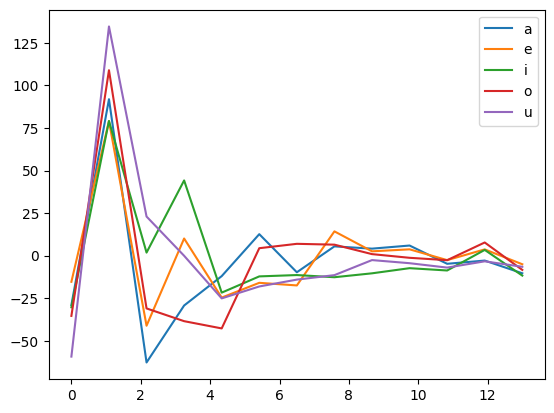

In [35]:
x = np.linspace(0,13,13)
for i in range(0,5):
    # flat_data = np.mean(mfccs_fts[i],axis=0)
    plt.plot(x,mfccs_fts_m[i],label=lbs[i])
plt.legend()
plt.show()

In [36]:
def min_euclidean_distance(_mfcc,mfccs_fts):
    min = euclidean_distance(np.mean(_mfcc,axis=1),mfccs_fts[0])
    index = 0
    for i in range(1,5):
        t = euclidean_distance(np.mean(_mfcc,axis=1),mfccs_fts[i])
        if(min > t):
            min = t
            index = i
    return index


In [37]:
def predict(mfccs_fts,data,lbs):
    true_labels = []
    pred_labels = []
    index = 0
    for d in data:
        for i in d:
            ste = STE(normalize_signal(i),frame_size,hop_size)

            signal = segement_signal(normalize_signal(i),ste=ste,ste_threshold=ste_threshold,frame_size=frame_size,hop_size=hop_size)

            divided_signal = divide_signal(signal=signal)

            mfccs = cal_mfccs(divided_signal)

            y_pred = min_euclidean_distance(mfccs,mfccs_fts=mfccs_fts)

            pred_labels.append(lbs[y_pred])

            true_labels.append(lbs[index])
        
        index +=1
    return true_labels,pred_labels
    

In [38]:
d_test,lbs_test = load_data(train_set=False)
true_labels,pred_labels = predict(mfccs_fts=mfccs_fts_m,data=d_test,lbs=lbs_test)

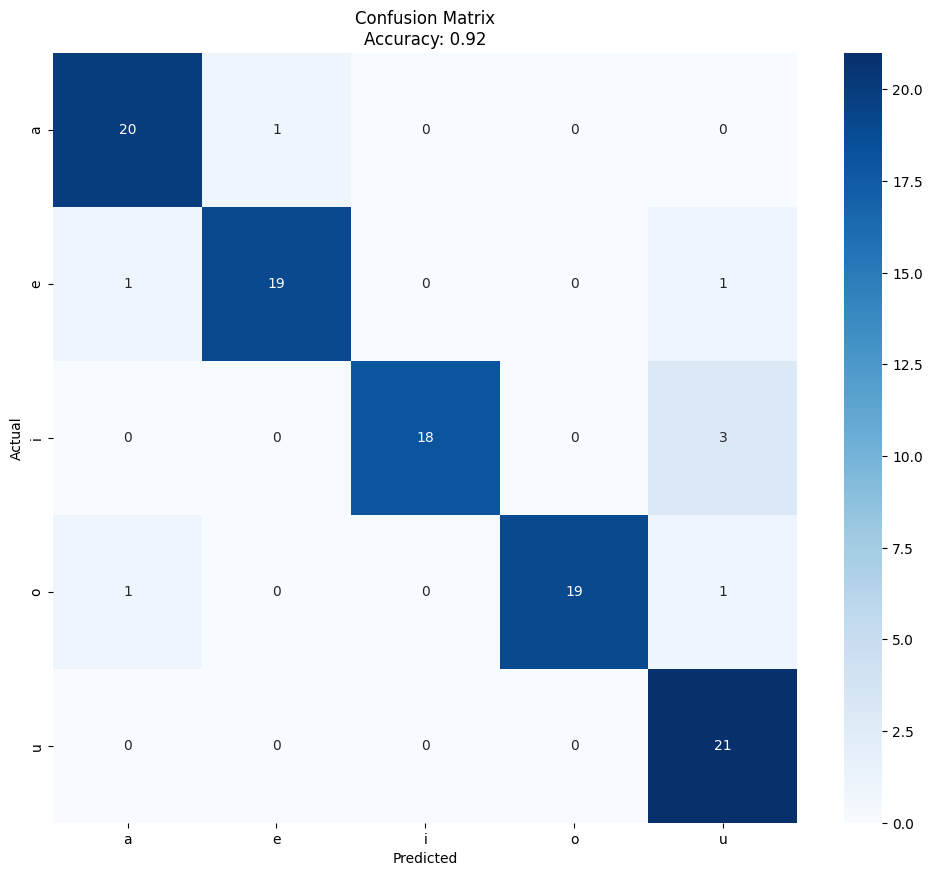

In [39]:

cm = confusion_matrix(true_labels, y_pred=pred_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d",vmin=0.0, vmax=21, cmap="Blues", cbar=True,
            xticklabels=np.unique(true_labels), yticklabels=np.unique(pred_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy_score(true_labels,pred_labels):.2f}')
plt.show()

In [18]:
mfccs_fts_k_mean = []
for d in data:
    te = []
    for i in d:
        ste = STE(normalize_signal(i),frame_size,hop_size)

        signal = segement_signal(normalize_signal(i),ste=ste,ste_threshold=ste_threshold,frame_size=frame_size,hop_size=hop_size)

        divided_signal = divide_signal(signal=signal)

        mfccs = cal_mfccs(divided_signal)
        # te.append(mfccs)
        te.append(np.mean(mfccs,axis=1))
        # te = np.concatenate(np.array(t),mfccs)
        
    mfccs_fts_k_mean.append(te)

In [58]:
v = [np.array(i).reshape(np.array(i).shape[0],-1) for i in mfccs_fts_k_mean]

In [19]:
from sklearn.cluster import KMeans

# fts = [np.array(i).flatten() for i in fts_kmean]
# mfccs_fts_k_mean = mfccs_fts
kmean_fts = []
n = []
for i in range(0,5):
    # temp = np.array(mfccs_fts_k_mean[i]).reshape(np.array(mfccs_fts_k_mean[i]).shape[0],-1)
    kmean = KMeans(n_clusters=3,random_state=21).fit(mfccs_fts_k_mean[i])
    kmean_fts.append(kmean.cluster_centers_)

d:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change

In [20]:
def predict_one(mfcc,kmean_mfccs):
    k = len(kmean_mfccs)
    l = len(kmean_mfccs[0])
    min = 9999999;
    index = 0
    for i in range(k):
        for j in range(l):
            if min > euclidean_distance(np.mean(mfcc,axis=1),kmean_mfccs[i][j]):
                min = euclidean_distance(np.mean(mfcc,axis=1),kmean_mfccs[i][j])
                index = i
    return index



In [21]:
def predict_kmean():
    data,lbs = load_data(train_set=False)
    true_labels = []
    pred_labels = []
    index = 0
    for d in data:
        for i in d:
            ste = STE(normalize_signal(i),frame_size,hop_size)

            signal = segement_signal(normalize_signal(i),ste=ste,ste_threshold=ste_threshold,frame_size=frame_size,hop_size=hop_size)

            divided_signal = divide_signal(signal=signal)

            mfccs = cal_mfccs(divided_signal)

            y_pred = predict_one(mfccs,kmean_mfccs=kmean_fts)

            pred_labels.append(lbs[y_pred])

            true_labels.append(lbs[index])
        
        index +=1
    return true_labels,pred_labels

In [22]:
tl,pl = predict_kmean()
# pl[70]

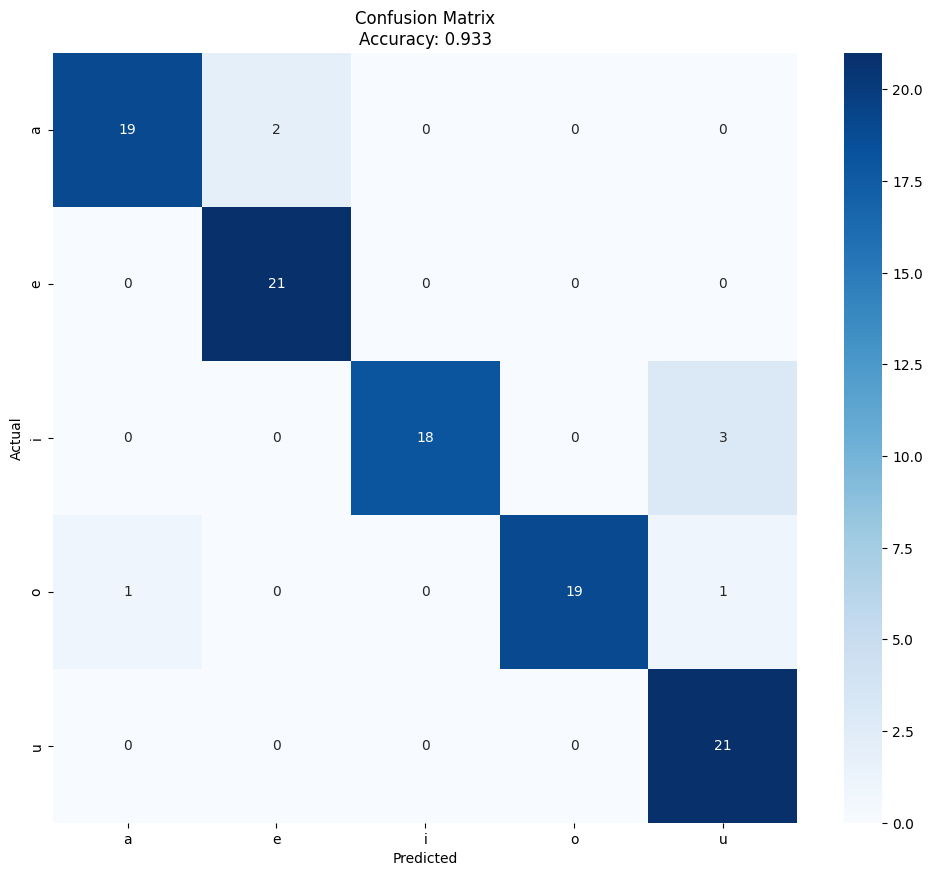

In [23]:

cm_km = confusion_matrix(tl, y_pred=pl)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_km, annot=True, fmt="d",vmin=0.0, vmax=21, cmap="Blues", cbar=True,
            xticklabels=np.unique(tl), yticklabels=np.unique(pl))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy_score(tl,pl):.3f}')
plt.show()

In [55]:
# frame_sizes = values
# hop_sizes = values
# threshold_sizes = values


d_train,l_train = load_data()
d_test,l_test = load_data(train_set=False)

rs =[]
for fr in range(80,640,80):
    for ho in range(80,640,80):
        for thr in np.arange(0.01,0.4,0.01):
            mfccs_ftss = []
            for d in d_train:
                ts = []
                for i in d:
                    st = STE(normalize_signal(i),fr,ho)
                    # print(st)
                    sig = segement_signal(normalize_signal(i),ste=st,ste_threshold=thr,frame_size=fr,hop_size=ho)

                    divided_sig = divide_signal(signal=sig)

                    mfccs_ = cal_mfccs(divided_sig)

                    ts.append(np.mean(mfccs_,axis=1))
                mfccs_ftss.append(ts)
            # print(len(mfccs_ftss))
            true_labels,pred_labels = predict(mfccs_fts=mfccs_ftss,data=d_test,lbs=lbs_test)
            accuracy__ = accuracy_score(true_labels,y_pred=pred_labels)

            rs.append([accuracy__,fr,ho,thr])            

C:\Users\minhn\AppData\Local\Temp\ipykernel_17240\2649907794.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate,audio = read(filename=file_path)
d:\python\Lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1840
  warnings.warn(
d:\python\Lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1920
  warnings.warn(
d:\python\Lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1253
  warnings.warn(
d:\python\Lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1467
  warnings.warn(
d:\python\Lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1653
  warnings.warn(
d:\python\Lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal

In [76]:
rs.sort()
print("best score & params:", rs[-1])

best score & params: [0.908123456765432, 400, 160, 0.02]


In [42]:
def load_data_with_path(train_set=True):
    if train_set:
        path = "./NguyenAmHuanLuyen-16k"
    else:
        path = "./NguyenAmKiemThu-16k"
    a,e,i,o,u = [],[],[],[],[]
    paths = []
    for subs,_,files in os.walk(path):
        for file in files:
            lb = file.split(".")[0]
            file_path = os.path.join(subs,file)
            paths.append(file_path)
            audio,_ = load_signal(file_path)
            match lb:
                case "a":
                    a.append(audio)
                case "e":
                    e.append(audio)
                case "i":
                    i.append(audio)
                case "o":
                    o.append(audio)
                case "u":
                    u.append(audio)
    data = []
    data.append(a)
    data.append(e)
    data.append(i)
    data.append(o)
    data.append(u)
    return data,["a","e","i","o","u"],paths


In [44]:
_,_,ps = load_data_with_path()
ps

C:\Users\minhn\AppData\Local\Temp\ipykernel_17240\2649907794.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate,audio = read(filename=file_path)


['./NguyenAmHuanLuyen-16k\\23MTL\\a.wav',
 './NguyenAmHuanLuyen-16k\\23MTL\\e.wav',
 './NguyenAmHuanLuyen-16k\\23MTL\\i.wav',
 './NguyenAmHuanLuyen-16k\\23MTL\\o.wav',
 './NguyenAmHuanLuyen-16k\\23MTL\\u.wav',
 './NguyenAmHuanLuyen-16k\\24FTL\\a.wav',
 './NguyenAmHuanLuyen-16k\\24FTL\\e.wav',
 './NguyenAmHuanLuyen-16k\\24FTL\\i.wav',
 './NguyenAmHuanLuyen-16k\\24FTL\\o.wav',
 './NguyenAmHuanLuyen-16k\\24FTL\\u.wav',
 './NguyenAmHuanLuyen-16k\\25MLM\\a.wav',
 './NguyenAmHuanLuyen-16k\\25MLM\\e.wav',
 './NguyenAmHuanLuyen-16k\\25MLM\\i.wav',
 './NguyenAmHuanLuyen-16k\\25MLM\\o.wav',
 './NguyenAmHuanLuyen-16k\\25MLM\\u.wav',
 './NguyenAmHuanLuyen-16k\\27MCM\\a.wav',
 './NguyenAmHuanLuyen-16k\\27MCM\\e.wav',
 './NguyenAmHuanLuyen-16k\\27MCM\\i.wav',
 './NguyenAmHuanLuyen-16k\\27MCM\\o.wav',
 './NguyenAmHuanLuyen-16k\\27MCM\\u.wav',
 './NguyenAmHuanLuyen-16k\\28MVN\\a.wav',
 './NguyenAmHuanLuyen-16k\\28MVN\\e.wav',
 './NguyenAmHuanLuyen-16k\\28MVN\\i.wav',
 './NguyenAmHuanLuyen-16k\\28MVN\\

In [47]:
def predict_false():
    d_test,lb_test,ps = load_data_with_path(train_set=False)
    index = 0
    n = 0;
    for d in d_test:
        for i in d:
            ste = STE(normalize_signal(i),frame_size,hop_size)

            signal = segement_signal(normalize_signal(i),ste=ste,ste_threshold=ste_threshold,frame_size=frame_size,hop_size=hop_size)

            divided_signal = divide_signal(signal=signal)

            mfccs = cal_mfccs(divided_signal)

            y_pred = predict_one(mfccs,kmean_mfccs=kmean_fts)

            # pred_labels.append(lbs[y_pred])

            # true_labels.append(lbs[index])
            if(lb_test[y_pred] != lb_test[index]):
                print()
                print("{dic} predict {vowel}".format(dic=ps[n],vowel=lb_test[y_pred]))
            n += 1
        index +=1
    

In [48]:
predict_false()


./NguyenAmKiemThu-16k\03MAB\u.wav predict e

./NguyenAmKiemThu-16k\04MHB\i.wav predict e

./NguyenAmKiemThu-16k\10MSD\a.wav predict u

./NguyenAmKiemThu-16k\10MSD\u.wav predict u

./NguyenAmKiemThu-16k\11MVD\e.wav predict u

./NguyenAmKiemThu-16k\15MMH\u.wav predict a

./NguyenAmKiemThu-16k\18MNK\e.wav predict u
